In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn-pastel')
import pandas as pd   # Works for pandas > v0.20
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 18,12

In [2]:
df = pd.read_csv("data/SampleSuperstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

# Univariate time series 
furniture_sales = furniture[['Order Date','Sales']]

# As read in as csv convert to date to datetime and make as the index
furniture_sales.sort_values('Order Date')
furniture_sales['Order Date'] = pd.to_datetime(furniture_sales['Order Date'])

# Sum the sales by date
furniture_sales = furniture_sales.groupby('Order Date')['Sales'].sum().reset_index()
furniture_sales = furniture_sales.set_index('Order Date')

# Create a monthly summary for EDA
furniture_sales_to_monthly = furniture_sales['Sales'].resample('MS').sum()

# Create a weekly set for predictions
furniture_sales_weekly = pd.DataFrame(furniture_sales['Sales'].resample('W').sum())

In [3]:
from sklearn.metrics import mean_squared_error
from pylab import rcParams
import math

def output_results(y_pred, full_dataset, title = 'Output Results', conf_int = []):
    
    y_values = y_pred # .predicted_mean
    
    fig = plt.figure()
    
    train_len = len(full_dataset) - len(y_values)
    
    rcParams['figure.figsize'] = 18,12
    
    rmse = math.sqrt(mean_squared_error(full_dataset[train_len:], y_values))
    title = title + ' - RMSE: {}'.format(str(round(rmse, 2)))    
    
    plt.xlabel('Date - Week Commencing')
    plt.ylabel('Sales')
    plt.plot(full_dataset[train_len:].index, y_values, label ='One Step Forecast', color = 'red')
    plt.plot(full_dataset[:train_len].index, full_dataset[:train_len], label = 'Training', color = 'blue')
    plt.plot(full_dataset[train_len:].index, full_dataset[train_len:], label = 'Observed', color = 'grey')
    plt.legend()
    
    if len(conf_int):
        plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='k', alpha=.2)
        
    
    fig.suptitle(title, fontsize=16)
    
    return plt, rmse

In [4]:
def shift_dataset(df, column_name, lags):  
    for each_lag in range(1,lags + 1):
        
        new_col = column_name + '_' + str(each_lag)
        df[new_col] = df[column_name].shift(each_lag)
         
    df.dropna(inplace = True)
    
    return df        

In [5]:
def split_data(df, train_split = 0.8):

    train_len = int(len(df) * train_split)

    train_data = df[:train_len]
    test_data = df[train_len:]

    y_train = train_data['Sales']
    X_train = train_data.drop(['Sales'], axis = 1)

    y_test = test_data['Sales']
    X_test = test_data.drop(['Sales'], axis = 1)

    X_all = df.drop(['Sales'], axis = 1)
    y_all = df['Sales']
    
    return X_all, y_all, X_train, y_train, X_test, y_test

In [6]:
import math
from sklearn.metrics import mean_squared_error, make_scorer

def RMSE(y_t,y_p):
    rmse = math.sqrt(mean_squared_error(y_t, y_p))
    return rmse

def rmse_scorer():
    return make_scorer(RMSE,  greater_is_better=False)
    

In [35]:
from sklearn.model_selection import GridSearchCV

def forecast_sales(df, shifts, mdl, param_grid, cv = 5, title = 'Linear Regression' ):

    best_models = []
    best_models_rmse = []
    best_rmse = 99999999

    for each_shift in shifts:

        furniture_sales_weekly_copy = df.copy()

        furniture_sales_weekly_shift = shift_dataset(furniture_sales_weekly_copy,'Sales', each_shift)

        X_all, y_all, X_train, y_train, X_test, y_test = split_data(furniture_sales_weekly_shift, 0.8)

        #mdl = LinearRegression()

        #param_grid = {'fit_intercept':('True', 'False')}

        grid = GridSearchCV(mdl, param_grid, scoring=rmse_scorer(), cv = cv, verbose = 1)  

        grid.fit(X_all, y_all)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))

        best_models.append(best_model)
        best_models_rmse.append(rmse)

        if best_rmse > rmse:
            final_model = best_model
            best_rmse = rmse
            best_lag = each_shift

    print ('Best lag: {}'.format(best_lag))
    print (best_model)
    
    y_pred = final_model.predict(X_test)
    rcParams['figure.figsize'] = 18,12
    plt, rmse = output_results(y_pred,furniture_sales_weekly['Sales'], title + ' Furniture Sales' )
    
    return plt

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best lag: 50
LinearRegression(copy_X=True, fit_intercept='True', n_jobs=None,
         normalize=False)


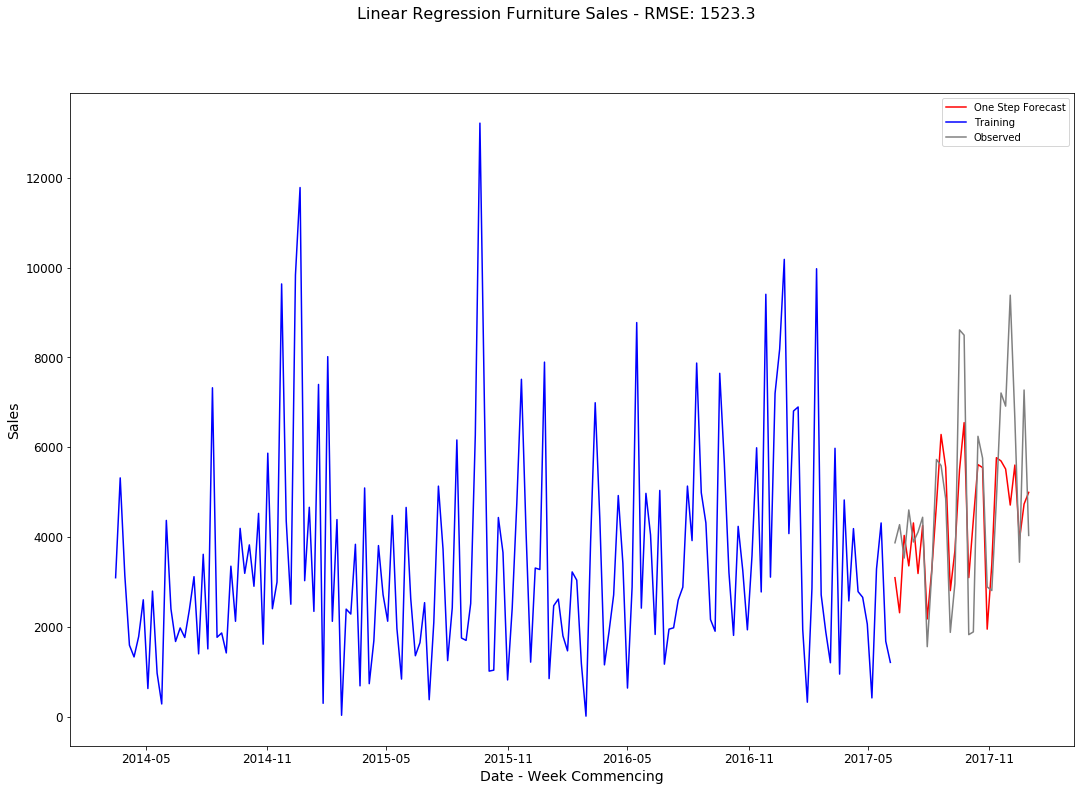

In [33]:
from sklearn.linear_model import LinearRegression

mdl = LinearRegression()
param_grid = {'fit_intercept':('True', 'False')}
shifts = [2,50]

plt_to_print = forecast_sales(furniture_sales_weekly, shifts, mdl, param_grid)

plt_to_print.savefig('images/LR.png')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best lag: 50
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


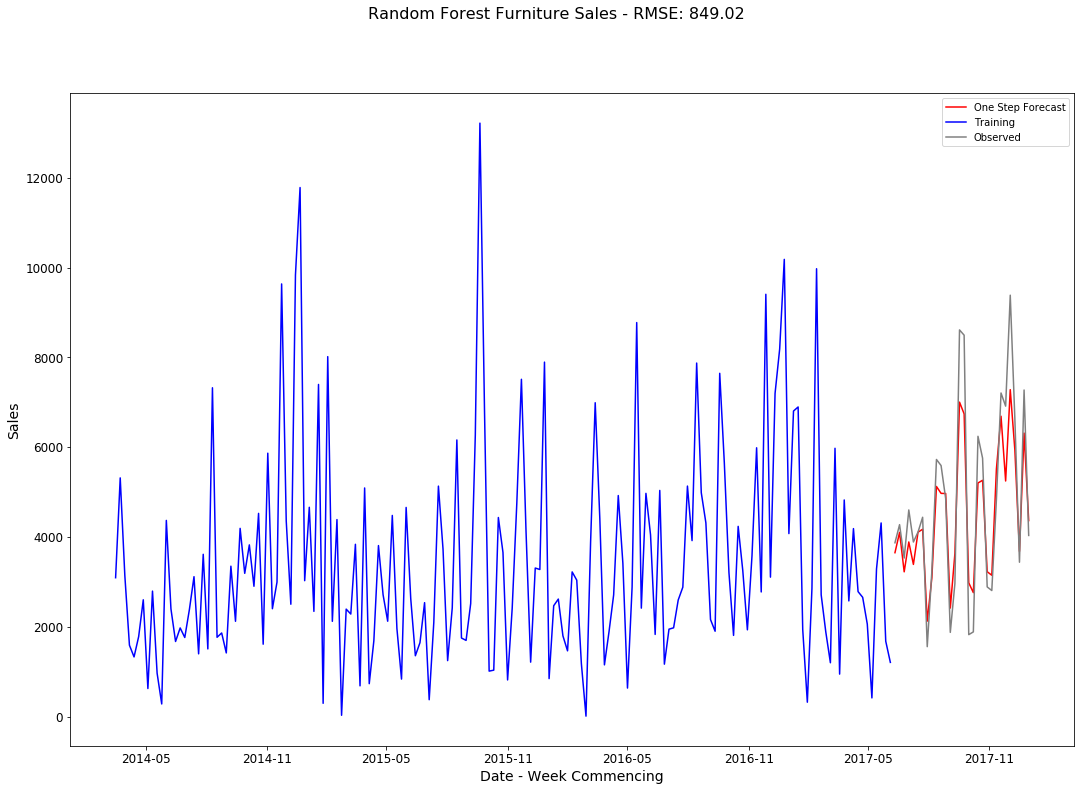

In [37]:
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor()
param_grid = {'max_depth':(None, 5, 10), 'n_estimators':(10,50,100)}
shifts = [10,50]

plt_to_print = forecast_sales(furniture_sales_weekly, shifts, mdl, param_grid, 5, 'Random Forest')

plt_to_print.savefig('images/RF.png')

In [26]:
df_temp = shift_dataset(furniture_sales_weekly, 'Sales', 5)
df_temp.head()

,Sales,Sales_1,Sales_2,Sales_3,Sales_4,Sales_5
Order Date,,,,,,
2014-03-16,3096.843,1724.976,0.000,45.480,1372.140,321.710
2014-03-23,5318.368,3096.843,1724.976,0.000,45.480,1372.140
2014-03-30,3146.383,5318.368,3096.843,1724.976,0.000,45.480
2014-04-06,1595.086,3146.383,5318.368,3096.843,1724.976,0.000
2014-04-13,1334.360,1595.086,3146.383,5318.368,3096.843,1724.976
